In [223]:
#import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.8)

import warnings
#warnings.SettingWithCopyWarning
pd.options.mode.chained_assignment = None

#read the collected 
df_init = pd.read_csv('final_movie_data.csv',index_col=0)

df = df_init.copy()
df.head(2)

,title,budget,revenue,genres,production_countries,production_companies,adult,popularity,original_language,release_date,runtime,vote_average,vote_count
0,Independence Day,75000000,817400891,"Action, Adventure, Science Fiction",United States of America,"Centropolis Entertainment, 20th Century Fox",False,17.068,en,1996-06-25,145.0,6.8,5595
1,The Matrix,63000000,463517383,"Action, Science Fiction","Australia, United States of America","Village Roadshow Pictures, Groucho II Film Par...",False,35.721,en,1999-03-30,136.0,8.1,14757


In [224]:
#####preprocessing#####

#fill missing values for run time with median
df.runtime.fillna(df_init.runtime.median(),inplace=True)

#fill mising values with 'missing'
df.genres.fillna('missing',inplace=True)
df.production_countries.fillna('missing',inplace=True)
df.production_companies.fillna('missing',inplace=True)

#rescale bugdet to list in million $
scale = 10**6
df['budget_M'] = df['budget'].div(scale)
df['revenue_M'] = df['revenue'].div(scale)

#total budget in million $ and %
df['return_M'] = df.revenue_M - df.budget_M
df['return_%'] = round(df.return_M/df.budget_M * 100, 2)

#add positive/negative return %
df['return_%_type'] = df['return_%'].map(lambda x: 'positive'
                                       if x > 0 else 'negative')

#add year column
df.release_date = df.release_date.astype('datetime64[ns]')
df['year'] = df.release_date.dt.year.fillna(0).astype('int64')

#add first genre column
df['first_genre'] = [x.split(', ')[0] if x is not np.nan 
                                           else np.nan for x in df.genres]
#add first company column
df['first_company'] = [x.split(', ')[0] if x is not np.nan 
                                             else np.nan for x in df.production_companies]
#add first country column
df['first_country'] = [x.split(', ')[0] if x is not np.nan 
                                             else np.nan for x in df.production_countries]

#select necessary columns
df = df[['title','year','first_genre','first_country','first_company',
         'budget_M','revenue_M','return_M','return_%','return_%_type','runtime']]   


df.head()

,title,year,first_genre,first_country,first_company,budget_M,revenue_M,return_M,return_%,return_%_type,runtime
0,Independence Day,1996,Action,United States of America,Centropolis Entertainment,75.0,817.400891,742.400891,989.87,positive,145.0
1,The Matrix,1999,Action,Australia,Village Roadshow Pictures,63.0,463.517383,400.517383,635.74,positive,136.0
2,The Matrix Reloaded,2003,Adventure,Australia,Heineken Branded Entertainment,150.0,738.599701,588.599701,392.40,positive,138.0
3,The Matrix Revolutions,2003,Adventure,United States of America,Silver Pictures,150.0,424.988211,274.988211,183.33,positive,129.0
4,Out of Africa,1985,History,United States of America,Universal Pictures,31.0,128.499205,97.499205,314.51,positive,161.0


In [225]:
df.describe()

,year,budget_M,revenue_M,return_M,return_%,runtime
count,5390.000000,5390.000000,5390.000000,5390.000000,5.390000e+03,5390.000000
mean,1957.975139,26.341708,72.503056,46.161348,1.038239e+06,108.587755
std,292.131867,62.940762,155.620346,138.332827,5.760174e+07,37.536488
min,0.000000,0.000001,-0.000012,-3499.050000,-2.000000e+02,1.000000
25%,1995.000000,2.000000,1.885835,-0.380014,-1.798000e+01,94.000000
50%,2006.000000,10.500000,16.163985,3.661137,9.507500e+01,105.000000
75%,2012.000000,30.000000,71.278307,40.591046,3.038250e+02,121.000000
max,2020.000000,3500.050000,2787.965087,2550.965087,4.166450e+09,2000.000000


In [226]:
df.describe(include=['object'])

,title,first_genre,first_country,first_company,return_%_type
count,5390,5390,5390,5390,5390
unique,5312,20,82,2322,2
top,The Three Musketeers,Drama,United States of America,missing,positive
freq,3,1305,2975,450,3654


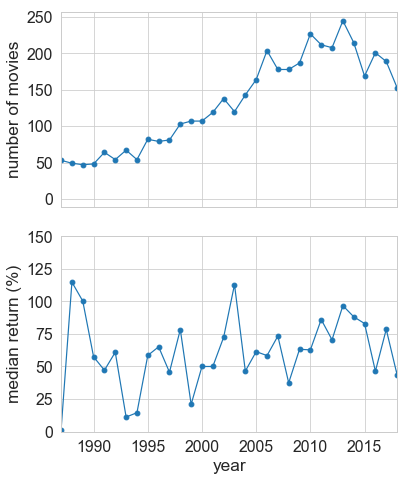

In [227]:
#What is distribution of movies by a year?
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,7),sharex=True)

#filter missing years and return greater than 1000%
filter_cond = (df.year > 0) & (df['return_%'] < 1000)

##subplot 1
#numbers of movies over time in the database
df[filter_cond].year.value_counts().sort_index()\
               .plot(kind='line',ax=ax1,marker='o')

#change axis labels
ax1.set_xlabel('year')
ax1.set_ylabel('number of movies')

##subplot 2
#Median return in % versus release year
df[filter_cond].groupby('year')['return_%'].median()\
               .plot(kind='line',ax=ax2,marker='o')

#change axis labels
ax2.set_xlabel('year')
ax2.set_ylabel('median return (%)')

#change axis limits
ax2.set_ylim(0,150)
ax2.set_xlim(1987,2018)

## zoom 

plt.tight_layout()

28.9% of movies have negative return.


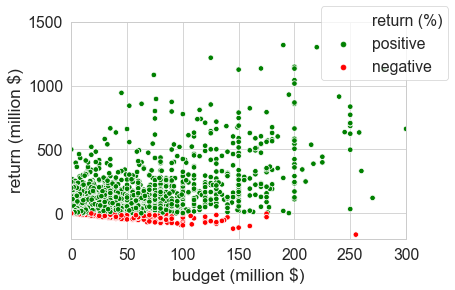

In [228]:
#How budget influence on total revenue in millions?
fig, ax1 = plt.subplots(1,1,figsize=(6,4))

#plot return vs budget in millions $
sns.scatterplot(x='budget_M', y='return_M', hue='return_%_type',
                data=df, s=30, ax=ax1,palette=['green','red'])

#change axis labels
ax1.set_xlabel('budget (million $)')
ax1.set_ylabel('return (million $)')

#legend parameters
ax1.legend(loc='right',bbox_to_anchor = [1.15, 0.9])\
   .texts[0].set_text("return (%)")

#change axis limits
ax1.set_xlim(0,300)
ax1.set_ylim(-200,1500)

#What is the percentage of movies with negative revenue?
neg_return = round(df[df.return_M < 0].shape[0] 
                   / df.shape[0] * 100,1)
print(f'{neg_return}% of movies have negative return.')

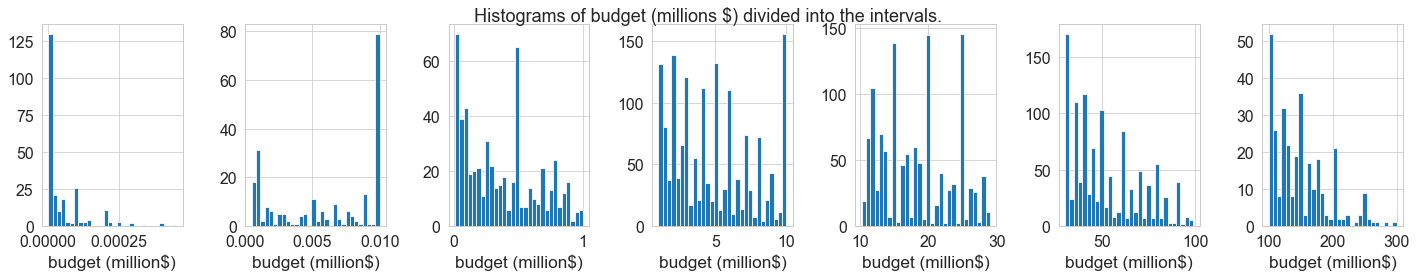

In [229]:
#What is distribution of movies by a budget?
#How to categorize the budget?
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,figsize=(20,4))

df[df.budget_M < 0.0005].budget_M.hist(bins=30,ax=ax1) #under 0.5k
ax1.set_xlabel('budget (million$)')

df[(df.budget_M >= 0.0005) & (df.budget_M <= 0.01)].budget_M.hist(bins=30,ax=ax2) #between 0.5k and 10k
ax2.set_xlabel('budget (million$)')

df[(df.budget_M > 0.01) & (df.budget_M < 1)].budget_M.hist(bins=30,ax=ax3) #between 10k and 1M
ax3.set_xlabel('budget (million$)')

df[(df.budget_M >= 1) & (df.budget_M <= 10)].budget_M.hist(bins=30,ax=ax4) #between 1M and 10M
ax4.set_xlabel('budget (million$)')

df[(df.budget_M > 10) & (df.budget_M < 30)].budget_M.hist(bins=30,ax=ax5) #between 10M and 30M
ax5.set_xlabel('budget (million$)')

df[(df.budget_M >= 30) & (df.budget_M < 100)].budget_M.hist(bins=30,ax=ax6) #between 30M and 100M
ax6.set_xlabel('budget (million$)')

df[(df.budget_M >= 100) & (df.budget_M <= 300)].budget_M.hist(bins=30,ax=ax7) #over 100M
ax7.set_xlabel('budget (million$)')

#add common title
plt.suptitle('Histograms of budget (millions $) divided into the intervals.',fontsize=18)
plt.tight_layout()

In [230]:
#add a new column with budget categories
df['budget_category'] = pd.cut(df.budget_M,[0,0.0005,0.01,1,10,30,100,1000],
                               labels=['< 0.5k','[0.5k, 10k]',
                                       '(10k, 1M)',
                                       '[1M, 10M]',
                                       '(10M, 30M)',
                                       '[30M, 100M)',
                                       '>= 100M'
                                      ])

,perc_25,median,perc_75
budget_category,,,
< 0.5k,-21.6650,0.00,92.8325
"[0.5k, 10k]",0.0000,50.00,317.1800
"(10k, 1M)",-1.7950,100.00,326.8675
"[1M, 10M]",-56.6200,63.85,242.5550
"(10M, 30M)",-41.1500,52.45,223.7475
"[30M, 100M)",-9.0075,80.67,206.2750
>= 100M,86.1700,175.59,318.0300


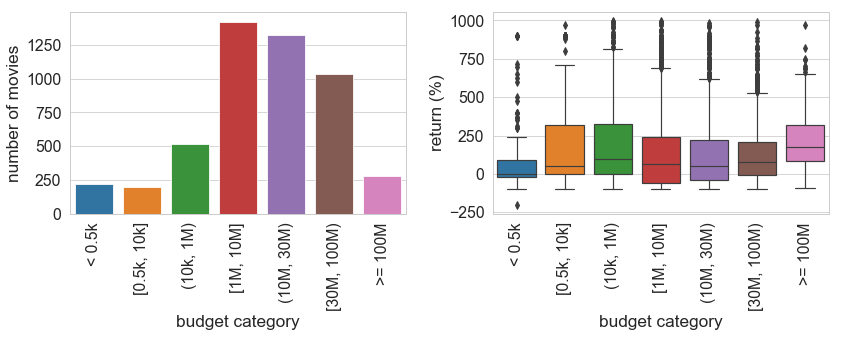

In [231]:
#return vs budget category: how much money to invest?
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

#filter the outliers in terms of return
filter_cond = (df['return_%'] < 1000)

#plot the number of movies versus budget category
sns.countplot(x='budget_category', data=df[filter_cond], ax=ax1)
#change axis labels
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_xlabel('budget category')
ax1.set_ylabel('number of movies')

#plot return in % versus budget category
sns.boxplot(x='budget_category',y='return_%',data=df[filter_cond],showfliers=True,ax=ax2)
#change axis labels
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_xlabel('budget category')
ax2.set_ylabel('return (%)')

plt.tight_layout()


#add table with median and 25,75 percentiles
def perc_25(x):
    return np.percentile(x, q = [25])
def perc_75(x):
    return np.percentile(x, q = [75])

df[filter_cond].groupby('budget_category')['return_%']\
               .agg([perc_25,np.median,perc_75])

budget_category,< 0.5k,"[0.5k, 10k]","(10k, 1M)","[1M, 10M]","(10M, 30M)","[30M, 100M)",>= 100M
select_genre,,,,,,,
Action,18,41,42,216,202,247,102
Adventure,5,2,12,48,78,104,78
Comedy,34,32,97,314,299,206,5
Crime,3,2,25,82,76,57,1
Drama,29,51,169,401,364,176,14
Horror,15,7,34,103,79,35,2
other,118,65,139,259,226,211,75


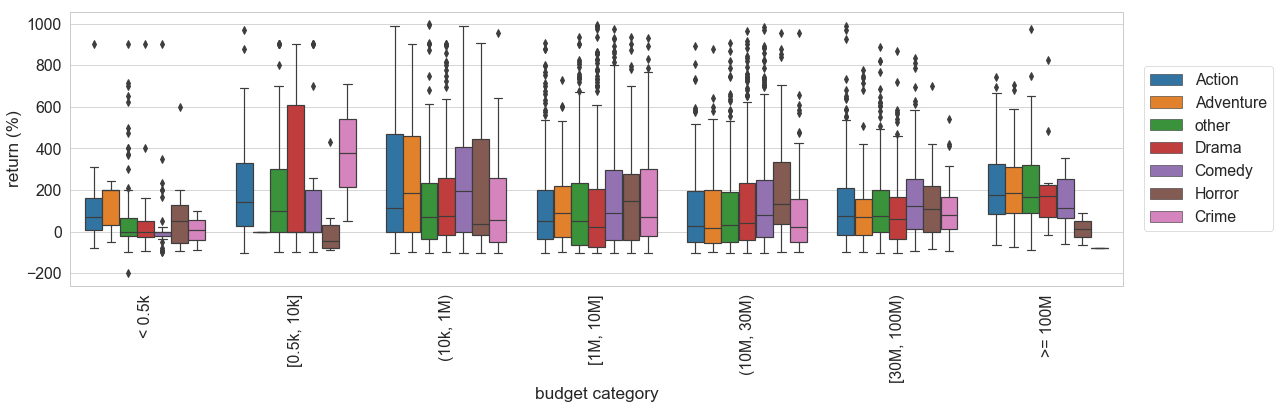

In [234]:
#How genre influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for most common genres
ax = sns.boxplot(x='budget_category',y='return_%',hue='select_genre',
            data=df[filter_cond],showfliers=True)

#change legend location
ax.legend(loc='right',bbox_to_anchor = [1.15, 0.5])
#change axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('budget category')
ax.set_ylabel('return (%)')

plt.tight_layout()

#add table showing numbers of movies in a given budget category and genre
df[filter_cond].groupby(['select_genre','budget_category'])\
                        ['budget_category'].count().unstack().fillna(0).astype('int64')

In [232]:
#analysis of categorical columns

#function to select top most frequent categories
def quick_cat(_series,top_number):
    #count values in a column and normalize to show percentage
    top = _series.value_counts(normalize=True)[:top_number]    
    
    print(f"Number of unique values is {_series.nunique()}.")
    print(f"The first {top_number} items are present in {round(top.sum()*100,1)} % of data.")
    
    return top

#select top most frequent genres
select_genre = quick_cat(df.first_genre,top_number=6).index
df['select_genre'] = df['first_genre'].map(lambda x: x if x in select_genre else 'other')

#select top most frequent countries
select_country = quick_cat(df.first_country,top_number=5).index
df['select_country'] = df['first_country'].map(lambda x: x if x in select_country else 'other')

#select top most frequent companies
select_company = quick_cat(df.first_company,top_number=20).index
df['select_company'] = df['first_company'].map(lambda x: x if x in select_company else 'other')

Number of unique values is 20.
The first 6 items are present in 78.1 % of data.
Number of unique values is 82.
The first 5 items are present in 77.3 % of data.
Number of unique values is 2322.
The first 20 items are present in 29.5 % of data.


budget_category,< 0.5k,"[0.5k, 10k]","(10k, 1M)","[1M, 10M]","(10M, 30M)","[30M, 100M)",>= 100M
select_country,,,,,,,
Canada,3,3,6,51,64,45,10
India,13,5,113,197,31,5,1
United Kingdom,11,4,16,94,95,58,31
United States of America,51,52,175,686,860,725,187
missing,90,52,74,43,8,2,1
other,54,84,134,352,266,201,47


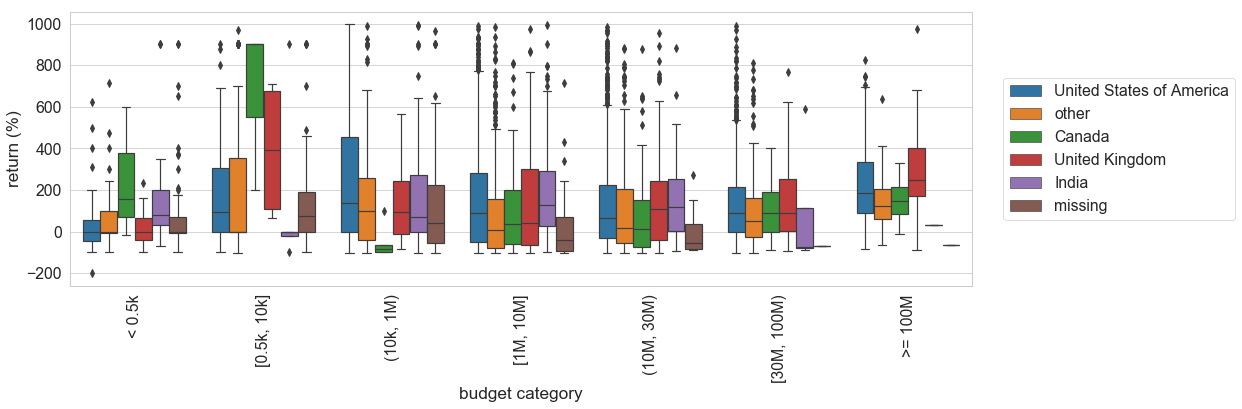

In [233]:
#How country influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for most common countries
ax = sns.boxplot(x='budget_category',y='return_%',hue='select_country',
            data=df[filter_cond],showfliers=True)
#change legend location
ax.legend(loc='right',bbox_to_anchor = [1.3, 0.5])
#change axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('budget category')
ax.set_ylabel('return (%)')

plt.tight_layout()

#add table showing numbers of movies in a given budget category and country
df[filter_cond].groupby(['select_country','budget_category'])\
                        ['budget_category'].count().unstack().fillna(0).astype('int64')

select_company,United Artists,Warner Bros. Pictures,Screen Gems,Fox Searchlight Pictures,20th Century Fox,Dimension Films,Walt Disney Pictures,Columbia Pictures,Universal Pictures,Paramount
median,193.61,180.0,161.23,159.83,152.71,146.775,123.44,117.5,113.89,109.65
count,39.00,55.0,31.00,21.00,43.00,28.000,73.00,99.0,157.00,156.00


select_company,Summit Entertainment,Metro-Goldwyn-Mayer,Touchstone Pictures,New Line Cinema,Miramax,other,Lionsgate,Village Roadshow Pictures,Orion Pictures,missing,TriStar Pictures
median,101.825,99.62,89.96,87.95,80.68,66.69,66.61,55.63,30.52,0.0,-7.92
count,20.000,61.00,53.00,81.00,29.00,3528.00,29.00,21.00,23.00,419.0,35.00


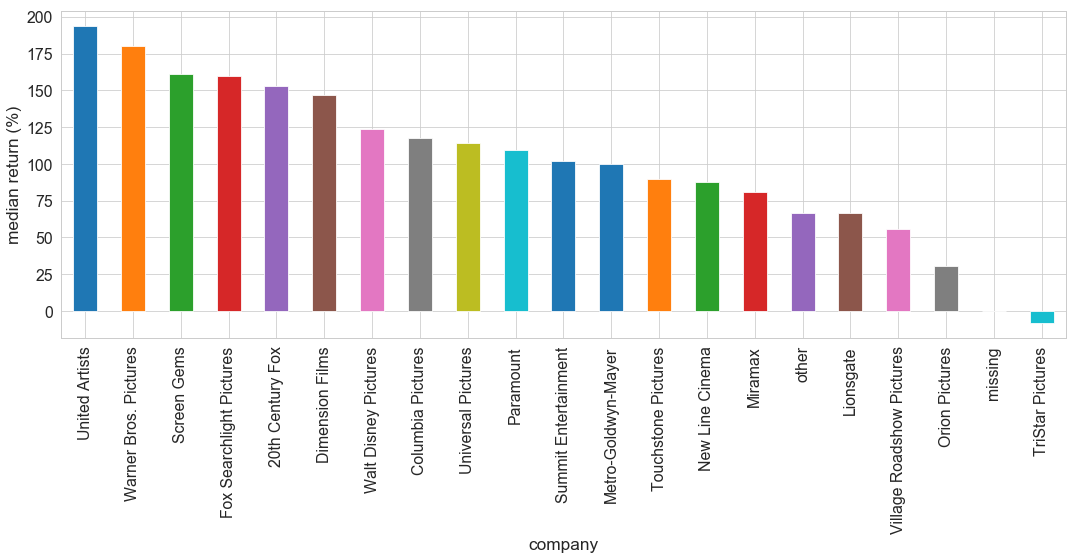

In [239]:
#How company influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for different companies
df[filter_cond].groupby('select_company')['return_%'].agg('median').sort_values(ascending=False)\
                                                     .plot(kind='bar',ax=ax)
#change axis labels
ax.set_ylabel('median return (%)')
ax.set_xlabel('company')


#display a table
d = df[filter_cond].groupby('select_company')['return_%'].agg(['median','count'])\
                   .sort_values(by='median',axis=0,ascending=False).transpose()

display(d.iloc[:,range(10)])
display(d.iloc[:,range(10,21)])

In [291]:
def plot_return_filter(filter_add,hue_by,hue_order,_xlim,_title):
    fig, ax = plt.subplots(1,1,figsize=(18,6))

    #plot return in % versus budget category for most common genres
    ax = sns.boxplot(x='budget_category',y='return_%',hue=hue_by,
                     hue_order = hue_order,
                     data=df[filter_cond & filter_add],showfliers=True)

    #change legend location
    ax.legend(loc='right',bbox_to_anchor = [1.15, 0.5])
    #change axis labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_xlabel('budget category')
    ax.set_ylabel('return (%)')
    ax.set_xlim(_xlim)
    ax.set_title(_title)

    plt.tight_layout()

In [275]:
#define order to compare different plots
hueorder = list(select_genre)
hueorder.append('other')
hueorder

['Drama', 'Comedy', 'Action', 'Adventure', 'Horror', 'Crime', 'other']

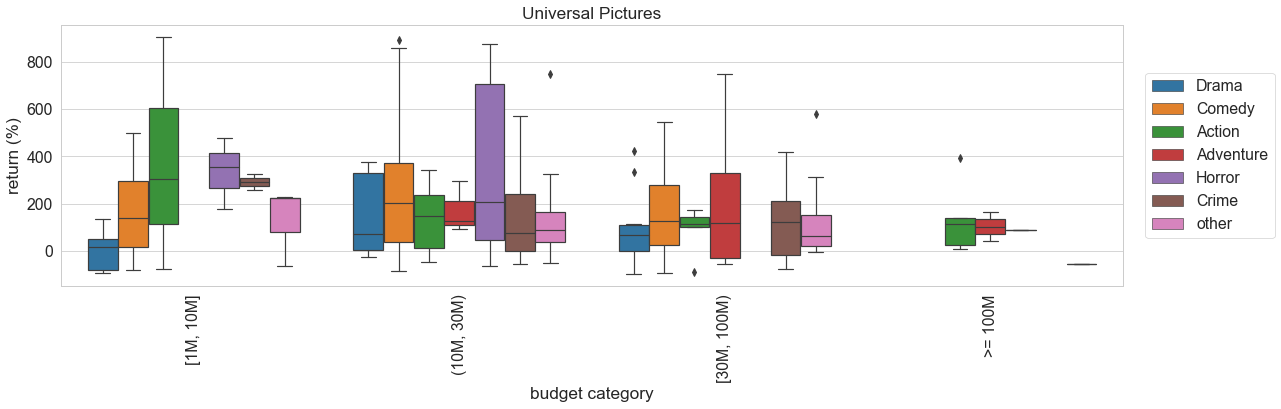

In [298]:
# return vs budget for most common genres
company = 'Universal Pictures' 
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _title = company)

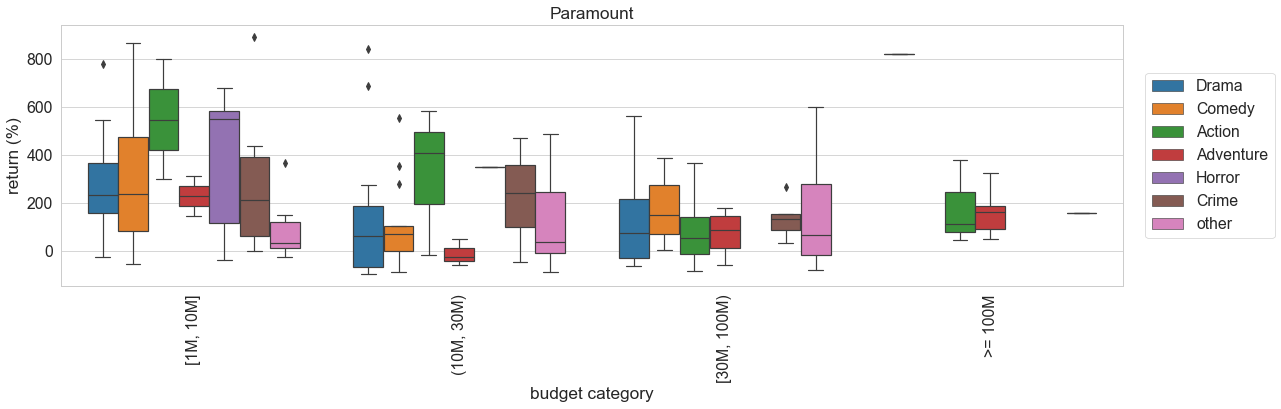

In [299]:
#return vs budget for most common genres
company = 'Paramount' 
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _title = company)

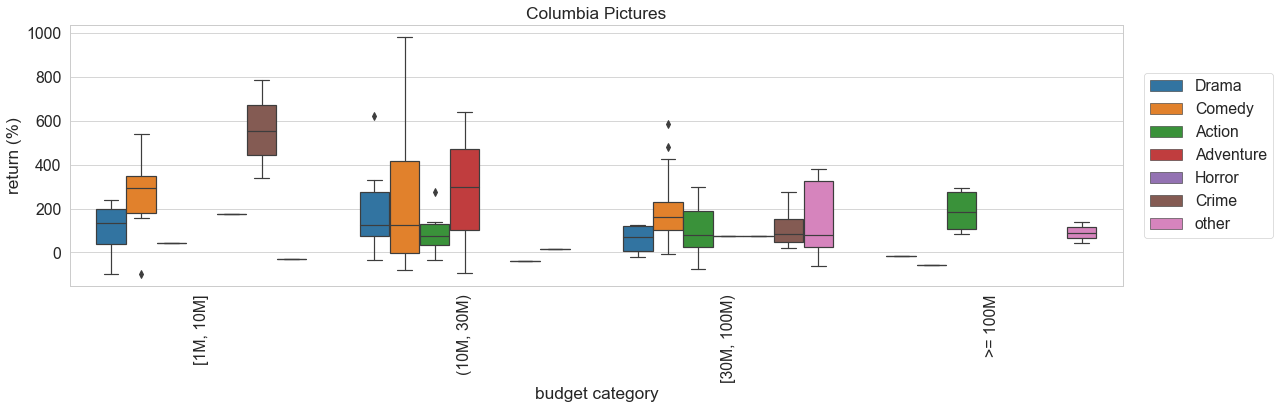

In [300]:
#return vs budget for most common genres
company = 'Columbia Pictures'
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _title =company)

### Questions to answer: How much money to invest? In what company? In what genre? 
 * For (1M,30M) budget choose Paramount company to film Action movies

Need to optimize return (%) (large median), minimaze risk (low std) for a given budget category.

In [331]:
#optimize return (%) (large median) and minimaze risk (low std)
filter_other = (df.select_company != 'other') & (df.select_company != 'missing') 

#First select budget range than company and after that genre
df[filter_cond & filter_other].groupby(['budget_category','select_company','select_genre'])['return_%']\
                              .agg(['count','median','std'])\
                              .sort_values(by='std',axis=0,ascending=True)\
                              .sort_values(by=['count','median'],axis=0,ascending=False).round(1).head(10)

count  median    std
budget_category select_company     select_genre                      
(10M, 30M)      Universal Pictures Comedy           16   205.1  323.8
[30M, 100M)     Paramount          Action           16    52.7  123.1
                Columbia Pictures  Comedy           14   160.8  176.4
                Universal Pictures Comedy           14   128.5  178.4
(10M, 30M)      New Line Cinema    Comedy           14    96.5  170.5
                Paramount          Comedy           14    69.9  176.4
                                   Drama            14    62.4  288.8
[1M, 10M]       Universal Pictures Comedy           13   138.4  186.0
[30M, 100M)     Columbia Pictures  Action           13    81.2  123.7
(10M, 30M)      Universal Pictures Drama            13    74.6  160.8